In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time
from PIL import Image
from scipy.interpolate import splrep, splev
# from numba import jit


In [2]:
# random seed
np.random.seed(11451419)

## Define function


In [3]:
from Vortex import *

In [4]:
# def defect_density(vortex_volume, r_grid):
#     d_voxel = r_grid[0][0,1,0]-r_grid[0][0,0,0]
#     d_cell = [(r_grid[0][0,-1,0]-r_grid[0][0,0,0]),
#               (r_grid[1][-1,0,0]-r_grid[1][0,0,0]),
#               (r_grid[2][0,0,-1]-r_grid[2][0,0,0])] 
#     sum_voxel = np.sum(vortex_volume) # total volume of defective voxels (pixel^3)
#     cross_voxel = 4 # crossection of defective voxels (pixel^2)
#     length = sum_voxel/cross_voxel # length of defect line (pixel)

#     cell_volume = d_cell[0]*d_cell[1]*d_cell[2]
#     line_density = length*d_voxel/cell_volume

#     return(line_density)

# def scale_rho(rho, r_grid, scale):
#     rho = ndimage.zoom(rho, scale, order=1)
#     r_grid = np.array([ndimage.zoom(r, scale, order=1) for r in r_grid]) 
#     return rho, r_grid

In [5]:
## Generate random wave
def gen_vertex_lines(r_grid, sigma_k, kappa, alpha, d, box_size, x_scale=1, n_grid_scale=128):
    #### Wave vector distribution ####
    scale = box_size/d/2 # how many layers in the box
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    ### generate randomwave
    rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa)

    scale_zoom = n_grid_scale/rho.shape[0]

    rho, r_grid = scale_rho(rho, r_grid, scale_zoom)

    rho_real = rho.real
    rho_imag = rho.imag
    rho_phase = np.angle(rho)

    vortex_volume = vortex_phase(rho_phase)

    ### Trace defect lines
    array = vortex_volume
    positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
    poslist_arr = np.array(positions_tuple_list)

    sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list, 
                                                    cluster_size=3)
    sample_ordered = get_ordered_points(sample, sample_adj_list)

    sample_ordered_sm = []
    for line in sample_ordered:
        if len(line) == 0:
            continue
        if len(line)>5:
            x = np.arange(len(line))
            x_fine = np.arange(len(line)*x_scale)/x_scale
            arr_line = np.array(line)
            spl_list = [splrep(x,arr_line[:,i],w=np.ones(len(line)),s=len(line)) for i in range(3)]
            line_sm = np.array([splev(x_fine,spl) for spl in spl_list]).T
            sample_ordered_sm.append(line_sm)
        # else:
        #     sample_ordered_sm.append(line)
    return r_grid, rho_real, vortex_volume, sample_ordered_sm


In [6]:
# @jit
# def index_d_pair(points,index_in,rr,d_cell,pbc):
#     index_d_jk = []
#     dr = rr[1]-rr[0]
#     for i in tqdm(index_in):
#         r_ik = points - points[i].reshape(1,3)
#         for i_3 in range(3):
#             r_ik[:,i_3] = r_ik[:,i_3]-np.floor(r_ik[:,i_3]/d_cell[i_3])*d_cell[i_3]*pbc[i_3] # PBC
#         d_ik = np.sqrt(np.sum(r_ik**2,axis=1)) # pair distances
#         d_ik_list = d_ik[d_ik!=0] # pair distances, self exclusive
        
#         index_d_ik = np.floor(d_ik_list/dr).astype(int)
#         index_d_jk.extend(index_d_ik)
#     index_d_jk = np.array(index_d_jk)
#     index_d_jk = index_d_jk[index_d_jk<nr]
#     return index_d_jk

def segment_corr(points, bounds, rr=[], pbc=[0,0,0], be=False, line=False, vectorized=False):
    """
    Calculate spatial correlation of line segments
    
    Args:
        points: array
                point coordinates, N by 3 array

        bounds: list
                box bounds

        rr: array
            pair distances

        pbc: list
             periodic boundary condition
    """
    N = points.shape[0]
    print(points.shape)
    max_r = np.max(rr)
    nr = len(rr)
    dr = rr[1]-rr[0]

    d_cell = [(bounds[0][1]-bounds[0][0]),
            (bounds[1][1]-bounds[1][0]),
            (bounds[2][1]-bounds[2][0])]

    V = d_cell[0]*d_cell[1]*d_cell[2]

    #### handling with finite size effect ####
    index_in = np.arange(N)
    N_in = N
    
    if be:
        index_in_0 = (points[:,0]>=bounds[0][0])*(points[:,0]<bounds[0][1])
        index_in_1 = (points[:,1]>=bounds[1][0])*(points[:,1]<bounds[1][1])
        index_in_2 = (points[:,2]>=bounds[2][0])*(points[:,2]<bounds[2][1])
        index_in = index_in_0*index_in_1*index_in_2
        N_in = np.sum(index_in)
        index_in = np.where(index_in)[0] # transform to coordinate of True's

    rho = N_in/V

    #### two-point correlation ####
    if vectorized:
        # vectorized
        r_jk = points[index_in].reshape(N_in,1,3) - points.reshape(1,N,3) # pair vector
        # r_jk = r_jk-np.floor(r_jk/d_cell[0])*d_cell[0] 
        for i in range(3):
            r_jk[:,:,i] = r_jk[:,:,i]-np.floor(r_jk[:,:,i]/d_cell[i])*d_cell[i]*pbc[i] # PBC
        d_jk = np.sqrt(np.sum(r_jk**2,axis=2)) # pair distances
        d_jk_list = d_jk[d_jk!=0] # pair distances, self exclusive

        index_d_jk = np.floor(d_jk_list/dr).astype(int)
        index_d_jk = index_d_jk[index_d_jk<nr]

    else:
        # index_d_jk = index_d_pair(points,index_in,rr,d_cell,pbc)
        index_d_jk = []
        for i in tqdm(index_in):
            r_ik = points - points[i].reshape(1,3)
            for i_3 in range(3):
                r_ik[:,i_3] = r_ik[:,i_3]-np.floor(r_ik[:,i_3]/d_cell[i_3])*d_cell[i_3]*pbc[i_3] # PBC
            d_ik = np.sqrt(np.sum(r_ik**2,axis=1)) # pair distances
            d_ik_list = d_ik[d_ik!=0] # pair distances, self exclusive
            index_d_ik = np.floor(d_ik_list/dr).astype(int)
            index_d_jk.extend(index_d_ik)
            
        index_d_jk = np.array(index_d_jk)
        index_d_jk = index_d_jk[index_d_jk<nr]

    #### histogram ####
    n_r = np.zeros(int(nr))
    g_r = np.zeros(int(nr))
    for index in index_d_jk:
        n_r[index]+=1
    
    # normalization
    for ir in range(int(nr)):
        r_i = rr[ir]-dr/2
        
        # assuming line-like geometry
        if line: 
            g_r[ir] = n_r[ir]/N_in/rho/dr
        else:
            g_r[ir] = n_r[ir]/N_in/rho/(4*np.pi*dr*r_i**2)

    return g_r

## Fitting results

In [7]:
'''
30%
d = 64.6432 +- 3.3425
sigma_k = 0.6726% +- 0.1121%
kappa = 3.7827 +- 0.6305
alpha = 0.7027 +- 0.1171
f_AOT = 24.1135% +- 3.6500%


40%
d = 48.9493 +- 2.0980
sigma_k = 0.7797% +- 0.1299%
kappa = 2.6546 +- 0.4424
alpha = 0.4926 +- 0.0821
f_AOT = 31.1141% +- 2.9012%


50%
d = 38.9151 +- 1.7524
sigma_k = 0.2560% +- 0.0427%
kappa = 1.6590 +- 0.2765
alpha = 0.2992 +- 0.0499
f_AOT = 38.2404% +- 1.9021%
'''
wt_list = [30,40,50]
d_list = [64.6432,48.9493,38.9151]
sigma_k_list = [0.6726e-2, 0.7797e-2, 0.2560e-2]
kappa_list = [3.7827, 2.6546, 1.6590]
alpha_list = [0.7027, 0.4926, 0.2992]

In [8]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]
box_size = 700
bounds = [[-250,250], [-250,250], [-250,250]]

## Generate random wave
n_grid = 100
n_grid_scale = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid_in = np.meshgrid(x,y,z) 

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
gr_list = []
for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    r_grid, rho_real, vortex_volume, sample_ordered_sm = gen_vertex_lines(r_grid_in, sigma_k, kappa, alpha, 
                                                                      d = d, box_size = box_size,
                                                                      x_scale=8, n_grid_scale = 128)
    sample_all = np.vstack(sample_ordered_sm)
    points = sample_all/n_grid_scale*box_size-box_size/2
    gr = segment_corr(points, bounds, rr=rr, pbc=[0,0,0], be=True)
    gr_list.append(gr)
    

(46464, 3)


100%|██████████| 16120/16120 [00:56<00:00, 287.39it/s]


(70984, 3)


100%|██████████| 24192/24192 [03:16<00:00, 123.20it/s]


(80152, 3)


100%|██████████| 29946/29946 [07:17<00:00, 68.40it/s]  


Text(0, 0.5, '$\\rho(r)$')

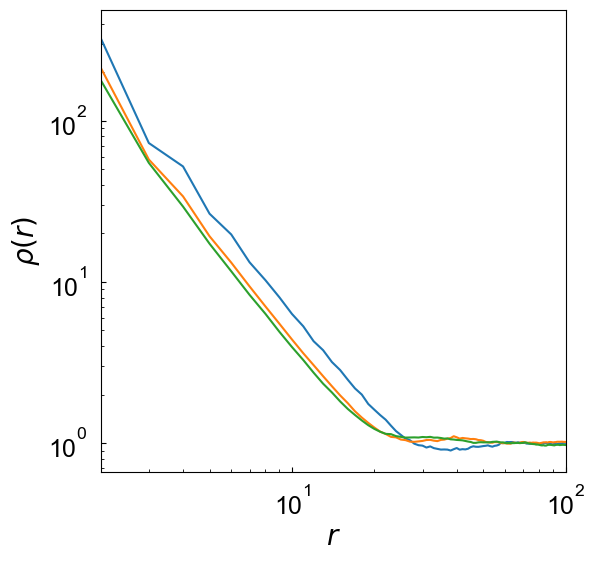

In [9]:
#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    ax.plot(rr, gr_list[i], '-')

ax.set_xlim([2,100])
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$\rho(r)$', fontsize=20)

Text(0, 0.5, '$\\rho(r)$')

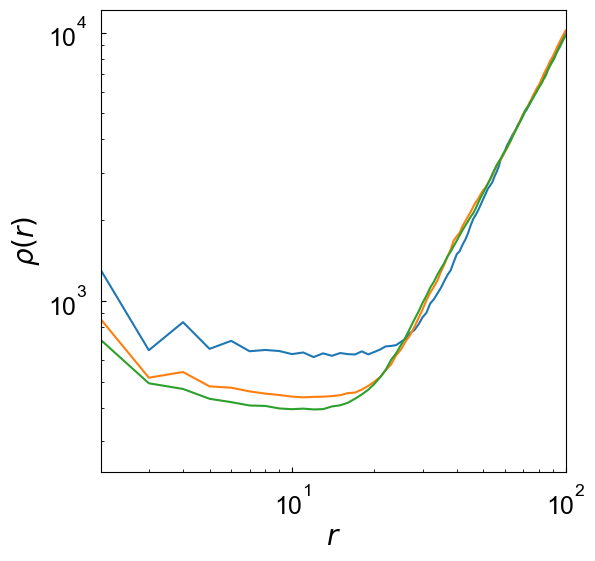

In [10]:
V = 700**3

#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    gr = gr_list[i]
    gr = gr*rr**2
    ax.plot(rr, gr, '-')

ax.set_xlim([2,100])
# ax.set_ylim([0,2])
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$\rho(r)$', fontsize=20)

(8000, 3)


  0%|          | 0/1541 [00:00<?, ?it/s]

100%|██████████| 1541/1541 [00:01<00:00, 1477.70it/s]


(0.0, 2.0)

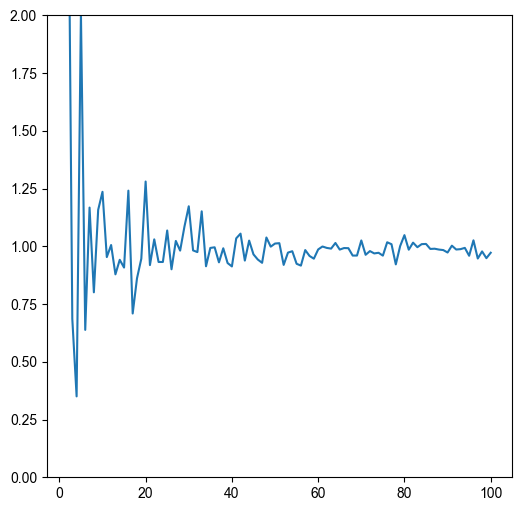

In [11]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]

bounds = [[-200,200], [-200,200], [-200,200]]

np.random.seed(None)
## 1. Random uniform box filling
points = np.random.rand(8000,3)*700-350
gr_be = segment_corr(points, bounds, rr=rr, be=True)

#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(rr[1:], gr[1:])
ax.plot(rr[1:], gr_be[1:])

ax.set_ylim([0,2])